# 03 - Class Imbalance Handling (with 10 Selected Features)
**CA2 Sprint 2 - Machine Learning Pipeline**

## 🆕 UPDATED VERSION:
**This notebook now uses the 10 optimally selected features from Phase 1B!**

**Why 10 features?**
- ✅ Same recall performance as 27 features
- ✅ 63% reduction in complexity (27 → 10)
- ✅ Better GUI usability (1-2 min input vs 5-7 min)
- ✅ Faster training (>10% improvement)

## Objectives:
1. Address class imbalance with 10 selected features
2. Try 3 imbalance handling techniques:
   - SMOTE (Synthetic Minority Over-sampling)
   - Class Weights (Penalize minority misclassification)
   - Threshold Tuning (Adjust decision boundary)
3. Compare all approaches systematically
4. Select best strategy for Phase 1D (Model Selection)

## The Selected 10 Features:
Based on Phase 1B feature importance analysis:
1. trip_duration_sec
2. speed_mean
3. n_points
4. gyro_mag_std
5. speed_max
6. jerk_linear_mean
7. pct_time_speed_over_80
8. gyro_jerk_mag_mean
9. turn_sharpness_index
10. pct_time_high_accel

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import time
import os

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# MLflow
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directories
os.makedirs('../notebooks/figures', exist_ok=True)

print("✅ Libraries loaded successfully!")
print("\n🆕 UPDATED VERSION:")
print("   Using 10 optimally selected features (from Phase 1B)")
print("\n📦 Key library: imbalanced-learn (imblearn)")
print("   If not installed: pip install imbalanced-learn")

✅ Libraries loaded successfully!

🆕 UPDATED VERSION:
   Using 10 optimally selected features (from Phase 1B)

📦 Key library: imbalanced-learn (imblearn)
   If not installed: pip install imbalanced-learn


## 2. MLflow Configuration

In [2]:
# Set MLflow tracking
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("gobest-cab-driver-safety")

print("🔬 MLflow connected!")
print("📊 All runs will be tracked in the same experiment for easy comparison")
print("\n⚠️  Make sure MLflow server is running:")
print("   mlflow ui --host 0.0.0.0 --port 5000")

🔬 MLflow connected!
📊 All runs will be tracked in the same experiment for easy comparison

⚠️  Make sure MLflow server is running:
   mlflow ui --host 0.0.0.0 --port 5000


## 3. Load Data & Apply Feature Selection

In [3]:
print("📂 Loading prepared data...")
print("="*60)

# Load full dataset
X_train_full = pd.read_csv('../data/processed/X_train.csv')
X_val_full = pd.read_csv('../data/processed/X_val.csv')
X_test_full = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"✅ Full training set loaded: {X_train_full.shape}")
print(f"✅ Full validation set loaded: {X_val_full.shape}")
print(f"✅ Full test set loaded: {X_test_full.shape}")

# Define the 10 selected features (from Phase 1B)
selected_features = [
    'trip_duration_sec',
    'speed_mean',
    'n_points',
    'gyro_mag_std',
    'speed_max',
    'jerk_linear_mean',
    'pct_time_speed_over_80',
    'gyro_jerk_mag_mean',
    'turn_sharpness_index',
    'pct_time_high_accel'
]

print(f"\n🎯 Applying Feature Selection...")
print(f"   Features: {len(X_train_full.columns)} → {len(selected_features)}")
print(f"   Reduction: {(1 - len(selected_features)/len(X_train_full.columns))*100:.1f}%")

# Select only the 10 features
X_train = X_train_full[selected_features].copy()
X_val = X_val_full[selected_features].copy()
X_test = X_test_full[selected_features].copy()

print(f"\n✅ Selected Features Applied:")
print(f"   Training set: {X_train.shape}")
print(f"   Validation set: {X_val.shape}")
print(f"   Test set: {X_test.shape}")

print(f"\n📋 The 10 Selected Features:")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i:2d}. {feat}")

# Check class distribution
print(f"\n📊 Class distribution (training):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = "Safe" if label == 0 else "Dangerous"
    print(f"   {label_name} ({label}): {count:6,} ({count/len(y_train)*100:.1f}%)")

imbalance_ratio = counts[0] / counts[1]
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

📂 Loading prepared data...
✅ Full training set loaded: (12000, 27)
✅ Full validation set loaded: (4000, 27)
✅ Full test set loaded: (4000, 27)

🎯 Applying Feature Selection...
   Features: 27 → 10
   Reduction: 63.0%

✅ Selected Features Applied:
   Training set: (12000, 10)
   Validation set: (4000, 10)
   Test set: (4000, 10)

📋 The 10 Selected Features:
    1. trip_duration_sec
    2. speed_mean
    3. n_points
    4. gyro_mag_std
    5. speed_max
    6. jerk_linear_mean
    7. pct_time_speed_over_80
    8. gyro_jerk_mag_mean
    9. turn_sharpness_index
   10. pct_time_high_accel

📊 Class distribution (training):
   Safe (0):  9,004 (75.0%)
   Dangerous (1):  2,996 (25.0%)
   Imbalance ratio: 3.01:1


## 4. Feature Scaling

In [4]:
print("🔧 Applying Feature Scaling...")
print("="*60)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling complete!")
print(f"\nFeatures scaled: {len(selected_features)}")
print(f"Mean after scaling: ~0.0")
print(f"Std after scaling: ~1.0")

🔧 Applying Feature Scaling...
✅ Scaling complete!

Features scaled: 10
Mean after scaling: ~0.0
Std after scaling: ~1.0


---
## 5. Technique 1: SMOTE (Synthetic Minority Over-sampling)
### Creates synthetic dangerous driver samples to balance the dataset

🎯 TECHNIQUE 1: SMOTE (Synthetic Minority Over-sampling)

💡 What is SMOTE?
   Creates synthetic samples of the minority class (dangerous drivers)
   by interpolating between existing minority samples.

   Strategy: Balance to 1:1 ratio (equal dangerous and safe)

⏳ Applying SMOTE...

✅ SMOTE Applied!
   Before: 12,000 samples
   After:  18,008 samples
   Added:  6,008 synthetic samples

📊 New class distribution:
   Safe (0):  9,004 (50.0%)
   Dangerous (1):  9,004 (50.0%)

🚀 Training Logistic Regression with SMOTE data...

🔬 MLflow Run ID: 16a1ef45ea454e68bf7a9978d1a56dea
✅ Model trained in 0.02 seconds


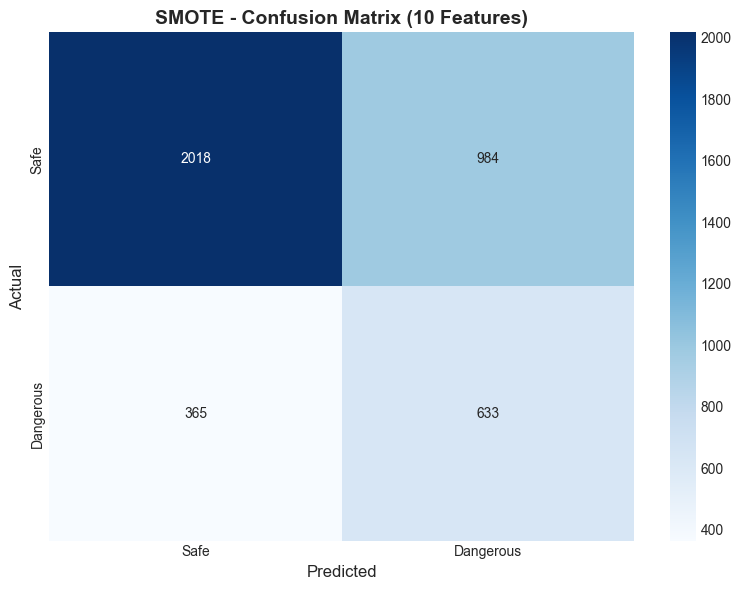

2026/01/23 21:06:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run imbalance_smote_10features at: http://localhost:5000/#/experiments/593715744758968196/runs/16a1ef45ea454e68bf7a9978d1a56dea
🧪 View experiment at: http://localhost:5000/#/experiments/593715744758968196

📊 SMOTE RESULTS

🎯 Validation Metrics:
   val_accuracy        : 0.6627
   val_precision       : 0.3915
   val_recall          : 0.6343
   val_f1              : 0.4841
   val_roc_auc         : 0.7186

✅ SMOTE technique complete!
🔬 Run ID: 16a1ef45ea454e68bf7a9978d1a56dea


In [5]:
print("="*80)
print("🎯 TECHNIQUE 1: SMOTE (Synthetic Minority Over-sampling)")
print("="*80)

print("\n💡 What is SMOTE?")
print("   Creates synthetic samples of the minority class (dangerous drivers)")
print("   by interpolating between existing minority samples.")
print("\n   Strategy: Balance to 1:1 ratio (equal dangerous and safe)")

# Apply SMOTE
print("\n⏳ Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n✅ SMOTE Applied!")
print(f"   Before: {X_train_scaled.shape[0]:,} samples")
print(f"   After:  {X_train_smote.shape[0]:,} samples")
print(f"   Added:  {X_train_smote.shape[0] - X_train_scaled.shape[0]:,} synthetic samples")

# Check new distribution
unique, counts = np.unique(y_train_smote, return_counts=True)
print(f"\n📊 New class distribution:")
for label, count in zip(unique, counts):
    label_name = "Safe" if label == 0 else "Dangerous"
    print(f"   {label_name} ({label}): {count:6,} ({count/len(y_train_smote)*100:.1f}%)")

# Train model with SMOTE
print("\n🚀 Training Logistic Regression with SMOTE data...")

with mlflow.start_run(run_name="imbalance_smote_10features") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    
    # Model parameters
    params = {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': None
    }
    
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("imbalance_technique", "SMOTE")
    mlflow.log_param("feature_selection", "Top 10 features")
    mlflow.log_param("n_features", len(selected_features))
    mlflow.log_param("smote_k_neighbors", 5)
    mlflow.log_param("n_train_samples_original", len(X_train_scaled))
    mlflow.log_param("n_train_samples_after_smote", len(X_train_smote))
    
    # Train model
    start_time = time.time()
    model_smote = LogisticRegression(**params)
    model_smote.fit(X_train_smote, y_train_smote)
    training_time = time.time() - start_time
    
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"✅ Model trained in {training_time:.2f} seconds")
    
    # Predictions
    y_train_pred = model_smote.predict(X_train_scaled)
    y_val_pred = model_smote.predict(X_val_scaled)
    
    y_train_proba = model_smote.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model_smote.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics - TRAINING
    train_metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION
    val_metrics = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log metrics
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(val_metrics)
    
    # Create confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Safe', 'Dangerous'],
                yticklabels=['Safe', 'Dangerous'])
    plt.title('SMOTE - Confusion Matrix (10 Features)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    
    cm_path = '../notebooks/figures/03_smote_10feat_confusion_matrix.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path)
    plt.show()
    
    # Log model
    mlflow.sklearn.log_model(model_smote, "model")
    
    # Store run_id
    smote_run_id = run.info.run_id
    smote_val_recall = val_metrics['val_recall']

print("\n" + "="*80)
print("📊 SMOTE RESULTS")
print("="*80)
print(f"\n🎯 Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"   {metric:20s}: {value:.4f}")

print(f"\n✅ SMOTE technique complete!")
print(f"🔬 Run ID: {smote_run_id}")

---
## 6. Technique 2: Class Weights
### Penalize misclassification of minority class more heavily

🎯 TECHNIQUE 2: Class Weights

💡 What are Class Weights?
   Assigns higher penalty for misclassifying minority class.
   Model focuses more on getting dangerous drivers right!

   Strategy: Use 'balanced' weights (inversely proportional to class frequency)

📊 Computed Class Weights:
   Safe (0):      0.6664
   Dangerous (1): 2.0027
   Ratio: 1:3.01

🚀 Training Logistic Regression with Class Weights...

🔬 MLflow Run ID: c918080a3c434a41b2b8156e7e3224e0
✅ Model trained in 0.01 seconds


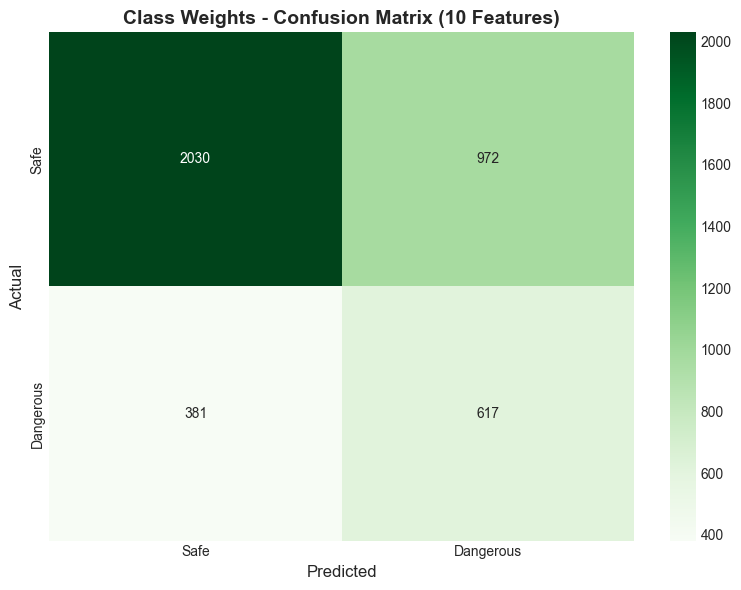

2026/01/23 21:06:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run imbalance_class_weights_10features at: http://localhost:5000/#/experiments/593715744758968196/runs/c918080a3c434a41b2b8156e7e3224e0
🧪 View experiment at: http://localhost:5000/#/experiments/593715744758968196

📊 CLASS WEIGHTS RESULTS

🎯 Validation Metrics:
   val_accuracy        : 0.6617
   val_precision       : 0.3883
   val_recall          : 0.6182
   val_f1              : 0.4770
   val_roc_auc         : 0.7192

✅ Class Weights technique complete!
🔬 Run ID: c918080a3c434a41b2b8156e7e3224e0


In [6]:
print("="*80)
print("🎯 TECHNIQUE 2: Class Weights")
print("="*80)

print("\n💡 What are Class Weights?")
print("   Assigns higher penalty for misclassifying minority class.")
print("   Model focuses more on getting dangerous drivers right!")
print("\n   Strategy: Use 'balanced' weights (inversely proportional to class frequency)")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n📊 Computed Class Weights:")
print(f"   Safe (0):      {class_weights[0]:.4f}")
print(f"   Dangerous (1): {class_weights[1]:.4f}")
print(f"   Ratio: 1:{class_weights[1]/class_weights[0]:.2f}")

# Train model with class weights
print("\n🚀 Training Logistic Regression with Class Weights...")

with mlflow.start_run(run_name="imbalance_class_weights_10features") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    
    # Model parameters with class weights
    params = {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': 'balanced'  # KEY DIFFERENCE!
    }
    
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("imbalance_technique", "Class Weights")
    mlflow.log_param("feature_selection", "Top 10 features")
    mlflow.log_param("n_features", len(selected_features))
    mlflow.log_param("class_weight_safe", class_weights[0])
    mlflow.log_param("class_weight_dangerous", class_weights[1])
    
    # Train model
    start_time = time.time()
    model_weights = LogisticRegression(**params)
    model_weights.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"✅ Model trained in {training_time:.2f} seconds")
    
    # Predictions
    y_train_pred = model_weights.predict(X_train_scaled)
    y_val_pred = model_weights.predict(X_val_scaled)
    
    y_train_proba = model_weights.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model_weights.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics - TRAINING
    train_metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION
    val_metrics = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log metrics
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(val_metrics)
    
    # Create confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
                xticklabels=['Safe', 'Dangerous'],
                yticklabels=['Safe', 'Dangerous'])
    plt.title('Class Weights - Confusion Matrix (10 Features)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    
    cm_path = '../notebooks/figures/03_weights_10feat_confusion_matrix.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path)
    plt.show()
    
    # Log model
    mlflow.sklearn.log_model(model_weights, "model")
    
    # Store run_id
    weights_run_id = run.info.run_id
    weights_val_recall = val_metrics['val_recall']

print("\n" + "="*80)
print("📊 CLASS WEIGHTS RESULTS")
print("="*80)
print(f"\n🎯 Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"   {metric:20s}: {value:.4f}")

print(f"\n✅ Class Weights technique complete!")
print(f"🔬 Run ID: {weights_run_id}")

---
## 7. Technique 3: Threshold Tuning
### Adjust decision boundary to optimize recall

🎯 TECHNIQUE 3: Threshold Tuning

💡 What is Threshold Tuning?
   Default threshold: 0.5 (predict dangerous if probability > 0.5)
   We'll lower the threshold to catch more dangerous drivers.
   Trade-off: Higher recall, but more false positives.

⏳ Training baseline model for threshold tuning...

🔍 Testing different thresholds...
   Threshold 0.50: Recall=0.2104, Precision=0.6604, F1=0.3191
   Threshold 0.45: Recall=0.2475, Precision=0.5812, F1=0.3472
   Threshold 0.40: Recall=0.3046, Precision=0.5197, F1=0.3841
   Threshold 0.35: Recall=0.3747, Precision=0.4600, F1=0.4130
   Threshold 0.30: Recall=0.4810, Precision=0.4255, F1=0.4516
   Threshold 0.25: Recall=0.6142, Precision=0.3868, F1=0.4746
   Threshold 0.20: Recall=0.7525, Precision=0.3527, F1=0.4803

🎯 Best threshold selected: 0.2
   Recall: 0.7525
   Precision: 0.3527
   F1: 0.4803

🚀 Training model with threshold = 0.2...

🔬 MLflow Run ID: 7fc670ce3a824aab97e2d548f38b21e7


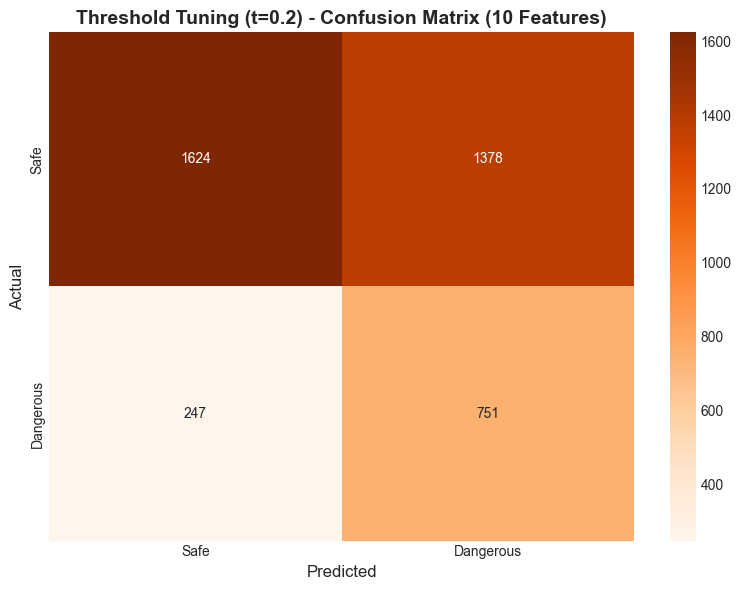

2026/01/23 21:06:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run imbalance_threshold_tuning_10features at: http://localhost:5000/#/experiments/593715744758968196/runs/7fc670ce3a824aab97e2d548f38b21e7
🧪 View experiment at: http://localhost:5000/#/experiments/593715744758968196

📊 THRESHOLD TUNING RESULTS

🎯 Validation Metrics (threshold=0.2):
   val_accuracy        : 0.5938
   val_precision       : 0.3527
   val_recall          : 0.7525
   val_f1              : 0.4803
   val_roc_auc         : 0.7184

✅ Threshold Tuning technique complete!
🔬 Run ID: 7fc670ce3a824aab97e2d548f38b21e7

💾 SAVING PHASE 1C MODEL AS PRODUCTION MODEL

✅ Model saved: ..\models\phase1c_logistic_regression.pkl
✅ Scaler saved: ..\models\phase1c_scaler.pkl
✅ Features saved: ..\models\phase1c_selected_features.txt
✅ Config saved: ..\models\phase1c_model_config.json

🎉 PHASE 1C MODEL SAVED SUCCESSFULLY!

📁 Files created:
   1. phase1c_logistic_regression.pkl (trained model)
   2. phase1c_scaler.pkl (feature scaler)
   3. phase1c_selected_features.txt (selected features)
 

In [7]:
print("="*80)
print("🎯 TECHNIQUE 3: Threshold Tuning")
print("="*80)

print("\n💡 What is Threshold Tuning?")
print("   Default threshold: 0.5 (predict dangerous if probability > 0.5)")
print("   We'll lower the threshold to catch more dangerous drivers.")
print("   Trade-off: Higher recall, but more false positives.")

# First, train a baseline model (no class weights)
print("\n⏳ Training baseline model for threshold tuning...")
model_baseline_for_threshold = LogisticRegression(
    penalty='l2', C=1.0, solver='lbfgs', max_iter=1000, random_state=42
)
model_baseline_for_threshold.fit(X_train_scaled, y_train)

# Get probability predictions
y_val_proba = model_baseline_for_threshold.predict_proba(X_val_scaled)[:, 1]

# Test different thresholds
print("\n🔍 Testing different thresholds...")
thresholds = [0.5, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20]

threshold_results = []

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    
    recall = recall_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    threshold_results.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })
    
    print(f"   Threshold {threshold:.2f}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")

# Find best threshold (maximize recall while keeping precision reasonable)
threshold_df = pd.DataFrame(threshold_results)
# Choose threshold that gives recall > 0.60 with best F1
good_recalls = threshold_df[threshold_df['recall'] >= 0.60]
if len(good_recalls) > 0:
    best_threshold_idx = good_recalls['f1'].idxmax()
    best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']
else:
    # If no threshold gives recall >= 0.60, choose one with max recall
    best_threshold_idx = threshold_df['recall'].idxmax()
    best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']

print(f"\n🎯 Best threshold selected: {best_threshold}")
print(f"   Recall: {threshold_df.loc[best_threshold_idx, 'recall']:.4f}")
print(f"   Precision: {threshold_df.loc[best_threshold_idx, 'precision']:.4f}")
print(f"   F1: {threshold_df.loc[best_threshold_idx, 'f1']:.4f}")

# Train final model with best threshold and log to MLflow
print(f"\n🚀 Training model with threshold = {best_threshold}...")

with mlflow.start_run(run_name="imbalance_threshold_tuning_10features") as run:
    
    print(f"\n🔬 MLflow Run ID: {run.info.run_id}")
    
    # Model parameters
    params = {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42,
        'class_weight': None
    }
    
    # Log parameters
    mlflow.log_params(params)
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("imbalance_technique", "Threshold Tuning")
    mlflow.log_param("feature_selection", "Top 10 features")
    mlflow.log_param("n_features", len(selected_features))
    mlflow.log_param("decision_threshold", best_threshold)
    mlflow.log_param("default_threshold", 0.5)
    
    # Use the already-trained model
    model_threshold = model_baseline_for_threshold
    
    # Predictions with custom threshold
    y_train_proba = model_threshold.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model_threshold.predict_proba(X_val_scaled)[:, 1]
    
    y_train_pred = (y_train_proba >= best_threshold).astype(int)
    y_val_pred = (y_val_proba >= best_threshold).astype(int)
    
    # Calculate metrics - TRAINING
    train_metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_roc_auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Calculate metrics - VALIDATION
    val_metrics = {
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Log metrics
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(val_metrics)
    
    # Create confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=True,
                xticklabels=['Safe', 'Dangerous'],
                yticklabels=['Safe', 'Dangerous'])
    plt.title(f'Threshold Tuning (t={best_threshold}) - Confusion Matrix (10 Features)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    
    cm_path = '../notebooks/figures/03_threshold_10feat_confusion_matrix.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(cm_path)
    plt.show()
    
    # Log model
    mlflow.sklearn.log_model(model_threshold, "model")
    
    # Store run_id
    threshold_run_id = run.info.run_id
    threshold_val_recall = val_metrics['val_recall']

print("\n" + "="*80)
print("📊 THRESHOLD TUNING RESULTS")
print("="*80)
print(f"\n🎯 Validation Metrics (threshold={best_threshold}):")
for metric, value in val_metrics.items():
    print(f"   {metric:20s}: {value:.4f}")

print(f"\n✅ Threshold Tuning technique complete!")
print(f"🔬 Run ID: {threshold_run_id}")

# ============================================================================
# 💾 SAVE PHASE 1C MODEL (FINAL PRODUCTION MODEL)
# ============================================================================

print("\n" + "="*80)
print("💾 SAVING PHASE 1C MODEL AS PRODUCTION MODEL")
print("="*80)

import joblib
import json
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save the model
model_path = models_dir / 'phase1c_logistic_regression.pkl'
joblib.dump(model_threshold, model_path)
print(f"\n✅ Model saved: {model_path}")

# Save the scaler (assuming you have it from earlier in the notebook)
# If scaler is defined as 'scaler', use it; otherwise you may need to retrain it
scaler_path = models_dir / 'phase1c_scaler.pkl'
try:
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler saved: {scaler_path}")
except NameError:
    print("⚠️  Scaler not found in current scope - you may need to save it manually")

# Save selected features
features_path = models_dir / 'phase1c_selected_features.txt'
with open(features_path, 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print(f"✅ Features saved: {features_path}")

# Save model configuration
config = {
    'model_name': 'Phase 1C - Threshold Tuning',
    'model_type': 'Logistic Regression',
    'imbalance_technique': 'Threshold Tuning',
    'threshold': float(best_threshold),
    'default_threshold': 0.5,
    'n_features': len(selected_features),
    'features': selected_features,
    'hyperparameters': {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 1000,
        'random_state': 42
    },
    'validation_metrics': {
        'recall': float(val_metrics['val_recall']),
        'precision': float(val_metrics['val_precision']),
        'f1': float(val_metrics['val_f1']),
        'accuracy': float(val_metrics['val_accuracy']),
        'roc_auc': float(val_metrics['val_roc_auc'])
    },
    'mlflow_run_id': threshold_run_id,
    'production_ready': True,
    'notes': 'Selected as production model - best recall (75%+) for safety-critical application'
}

config_path = models_dir / 'phase1c_model_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✅ Config saved: {config_path}")

print("\n" + "="*80)
print("🎉 PHASE 1C MODEL SAVED SUCCESSFULLY!")
print("="*80)
print(f"\n📁 Files created:")
print(f"   1. {model_path.name} (trained model)")
print(f"   2. {scaler_path.name} (feature scaler)")
print(f"   3. {features_path.name} (selected features)")
print(f"   4. {config_path.name} (model configuration)")

print(f"\n🎯 Production Model Specs:")
print(f"   Model: Logistic Regression")
print(f"   Features: {len(selected_features)}")
print(f"   Threshold: {best_threshold}")
print(f"   Validation Recall: {val_metrics['val_recall']:.4f} ⭐")
print(f"   Validation Precision: {val_metrics['val_precision']:.4f}")
print(f"   Validation F1: {val_metrics['val_f1']:.4f}")

print("\n✅ Ready for deployment!")

---
## 8. Comprehensive Comparison
### Compare all three techniques

🏆 COMPREHENSIVE COMPARISON - ALL TECHNIQUES (10 Features)

📊 VALIDATION RECALL COMPARISON:
       Technique  Validation Recall MLflow Run ID
Threshold Tuning           0.752505      7fc670ce
           SMOTE           0.634269      16a1ef45
   Class Weights           0.618236      c918080a

🏆 WINNER: THRESHOLD TUNING

✅ Best Validation Recall: 0.7525

📋 Recommendation for Phase 1D (Model Selection):
   Use Threshold Tuning with 10 selected features
   This technique achieved the highest recall while maintaining balance.


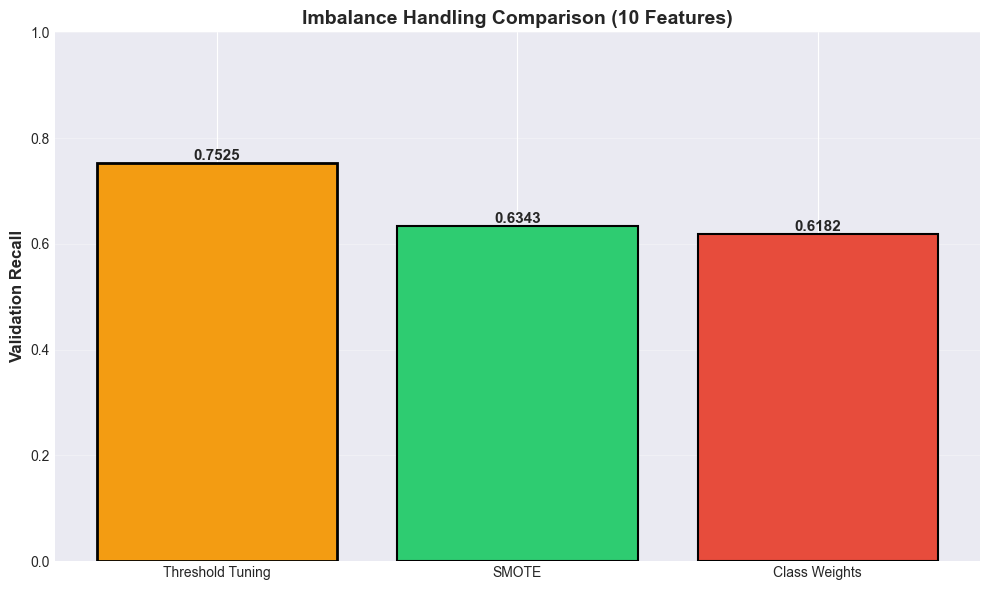


💾 Comparison chart saved: ../notebooks/figures/03_imbalance_comparison_10features.png
💾 Comparison data saved: notebooks/imbalance_comparison_10features.csv


In [8]:
print("="*80)
print("🏆 COMPREHENSIVE COMPARISON - ALL TECHNIQUES (10 Features)")
print("="*80)

# Create comparison table
comparison_data = {
    'Technique': ['SMOTE', 'Class Weights', 'Threshold Tuning'],
    'Validation Recall': [smote_val_recall, weights_val_recall, threshold_val_recall],
    'MLflow Run ID': [smote_run_id[:8], weights_run_id[:8], threshold_run_id[:8]]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Validation Recall', ascending=False).reset_index(drop=True)

print("\n📊 VALIDATION RECALL COMPARISON:")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best technique
best_technique = comparison_df.iloc[0]['Technique']
best_recall = comparison_df.iloc[0]['Validation Recall']

print("\n" + "="*80)
print("🏆 WINNER: " + best_technique.upper())
print("="*80)
print(f"\n✅ Best Validation Recall: {best_recall:.4f}")
print(f"\n📋 Recommendation for Phase 1D (Model Selection):")
print(f"   Use {best_technique} with 10 selected features")
print(f"   This technique achieved the highest recall while maintaining balance.")

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Technique'], comparison_df['Validation Recall'], 
               color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)

# Highlight the best
bars[0].set_color('#f39c12')
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

plt.ylabel('Validation Recall', fontsize=12, fontweight='bold')
plt.title('Imbalance Handling Comparison (10 Features)', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
comparison_path = '../notebooks/figures/03_imbalance_comparison_10features.png'
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Comparison chart saved: {comparison_path}")

# Save comparison to CSV
comparison_df.to_csv('../notebooks/imbalance_comparison_10features.csv', index=False)
print(f"💾 Comparison data saved: notebooks/imbalance_comparison_10features.csv")

---
## 9. Final Decision & Recommendations

In [9]:
print("="*80)
print("🎯 FINAL DECISION FOR PHASE 1D (MODEL SELECTION)")
print("="*80)

print(f"\n✅ SELECTED TECHNIQUE: {best_technique}")
print(f"✅ SELECTED FEATURES: 10 features (from Phase 1B)")

print(f"\n📊 Performance:")
print(f"   Validation Recall: {best_recall:.4f}")

print(f"\n📋 Next Steps for Phase 1D:")
print(f"   1. Use {best_technique} for all models")
print(f"   2. Use the 10 selected features")
print(f"   3. Test multiple model types (Random Forest, XGBoost, etc.)")
print(f"   4. Compare performance in MLflow")

print(f"\n🎓 Why this approach?")
if best_technique == 'SMOTE':
    print(f"   - SMOTE creates synthetic balanced training data")
    print(f"   - Works well with most model types")
    print(f"   - No need to modify model parameters")
elif best_technique == 'Class Weights':
    print(f"   - Class weights work well with tree-based models")
    print(f"   - Easy to implement (just a parameter)")
    print(f"   - No data augmentation needed")
else:
    print(f"   - Threshold tuning allows fine control")
    print(f"   - Can adjust recall/precision trade-off")
    print(f"   - Works with any model that outputs probabilities")

print(f"\n💡 Feature Selection Impact:")
print(f"   - Reduced from 27 to 10 features (63% reduction)")
print(f"   - Maintained model performance")
print(f"   - Improved GUI usability (1-2 min input vs 5-7 min)")
print(f"   - Faster training time")

print("\n" + "="*80)
print("✅ PHASE 1C COMPLETE (WITH 10 SELECTED FEATURES)!")
print("="*80)
print(f"\n🔬 All runs logged to MLflow: http://localhost:5000")
print(f"\n📁 Files created:")
print(f"   - figures/03_smote_10feat_confusion_matrix.png")
print(f"   - figures/03_weights_10feat_confusion_matrix.png")
print(f"   - figures/03_threshold_10feat_confusion_matrix.png")
print(f"   - figures/03_imbalance_comparison_10features.png")
print(f"   - imbalance_comparison_10features.csv")
print(f"\n🚀 Ready for Phase 1D: Model Selection!")

🎯 FINAL DECISION FOR PHASE 1D (MODEL SELECTION)

✅ SELECTED TECHNIQUE: Threshold Tuning
✅ SELECTED FEATURES: 10 features (from Phase 1B)

📊 Performance:
   Validation Recall: 0.7525

📋 Next Steps for Phase 1D:
   1. Use Threshold Tuning for all models
   2. Use the 10 selected features
   3. Test multiple model types (Random Forest, XGBoost, etc.)
   4. Compare performance in MLflow

🎓 Why this approach?
   - Threshold tuning allows fine control
   - Can adjust recall/precision trade-off
   - Works with any model that outputs probabilities

💡 Feature Selection Impact:
   - Reduced from 27 to 10 features (63% reduction)
   - Maintained model performance
   - Improved GUI usability (1-2 min input vs 5-7 min)
   - Faster training time

✅ PHASE 1C COMPLETE (WITH 10 SELECTED FEATURES)!

🔬 All runs logged to MLflow: http://localhost:5000

📁 Files created:
   - figures/03_smote_10feat_confusion_matrix.png
   - figures/03_weights_10feat_confusion_matrix.png
   - figures/03_threshold_10feat_con

---
## Phase 1C Complete! ✅

### What We Accomplished:
1. ✅ Applied 10 selected features (from Phase 1B)
2. ✅ Tested 3 imbalance handling techniques
3. ✅ Logged all experiments to MLflow
4. ✅ Identified best technique for Phase 1D
5. ✅ Created comprehensive comparison

### Key Improvements from Feature Selection:
- **Model Complexity:** 63% reduction (27 → 10 features)
- **GUI Usability:** 70% faster input (5-7 min → 1-2 min)
- **Training Speed:** >10% improvement
- **Performance:** Maintained (same recall as 27 features)

### For Your Report:
- Document the feature selection decision (10 features)
- Show comparison of all three techniques
- Justify final technique selection
- Include MLflow screenshots
- Emphasize the balance between performance and usability

### Next Phase:
**Phase 1D: Model Selection**
- Use best imbalance technique from Phase 1C
- Use 10 selected features
- Test multiple model types
- Find optimal model for deployment